In [130]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.coord as afwCoord
import matplotlib
import matplotlib.pylab as plt
import numpy as np

from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask

from astropy.table import Table

# List of visits to be considered
visits = [7276]
#visits = [7274, 7276, 7420, 7422, 14108, 14112, 38074, 38080]

# Tract
tract = 0

# List of CCD to be considered (source calatlogs will be concateneted)
#ccd = [12, 13, 14, 21, 22, 23]
ccd = range(104)
ccd.pop(9) # Remove bad CCD

filter = 'HSC-I'

#setup butler
butler = dafPersist.Butler("/sps/lsst/dev/lsstprod/hsc/SXDS/output")

In [133]:
# Get reference catalog

refConfig = LoadIndexedReferenceObjectsTask.ConfigClass()
refConfig.ref_dataset_name = 'pan-starrs'
#refConfig.ref_dataset_name = 'gaia'
#refConfig.ref_dataset_name = 'sdss'
refTask = LoadIndexedReferenceObjectsTask(butler, config=refConfig)

filt = 'i'
#filt = 'phot_g_mean_mag'
#filt = 'R'
fluxType = "base_PsfFlux_flux"

center = afwCoord.Coord('2:18:00', '-5:00:00')
radius = 1.0
skyCircle = refTask.loadSkyCircle(center,
                                        afwGeom.Angle(radius, afwGeom.degrees), filt)

refCat = skyCircle.refCat.copy(deep=True)

In [9]:
def flToMag(flux):
    return -2.5 * np.log10(flux/3631.)

def flToMagErr (flux, fluxErr):
    return np.abs(fluxErr / (-0.4 * flux *np.log(10)))

In [138]:
fluxType = "base_PsfFlux"
Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", fluxType + "_flag"]

init = True
flagKey = []

T = Table(names=("distNew", "distOld", "visit", "ccdVis", "mag", "ra", "dec"), 
          dtype=('f', 'f', 'i', 'i2', 'f', 'S12', 'S12'))

for v in visits:
    for c in ccd:
        if v == 38074 and c == 77:
            continue
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        src = butler.get('src', dataid, immediate=True)

        if init == True:
            # get some keys from the source catalog schema
            schema = src.getSchema()
            for f in Flags :
                key = schema[f].asKey()
                flagKey.append(key)
                init = False
            fluxKey = schema[fluxType + "_flux"].asKey()
            fluxSigmaKey = schema[fluxType + '_fluxSigma'].asKey()

        # retrieve the calibration object associated to the CCDs
        mdRef = butler.get("calexp_md", dataid, immediate=True)
        calib = afwImage.Calib(mdRef)

        # retrieve the original and improved wcs
        oldWcs = afwImage.makeWcs(mdRef)
        dataidNew = {'visit':v, 'filter':filter, 'ccd':c, 'tract':tract}
        newWcsCont = butler.get('wcs', dataidNew, immediate=True)
        newWcs = newWcsCont.getWcs()

        # match source catalog to external reference
        match = afwTable.matchRaDec(refCat, src, afwGeom.Angle(3./3600., afwGeom.degrees))
        print(len(match))

        # reject bad sources
        for m in match :
            mRef = m.first
            mVis = m.second

            for f in flagKey:
                rej = 0
                if mRef.get(f) :
                    rej = 1
                    break
            if rej == 1 :
                continue

            # do not consider bad sources
            flux = mVis.get(fluxKey)
            fluxSigma = mVis.get(fluxSigmaKey)
            if flux /fluxSigma < 5 :
                continue
            if flux > 0. :
                 mag = calib.getMagnitude(flux)
            else :
                continue
            if mag < 17 or mag > 23 :
                continue

            footprint = mVis.getFootprint()
            if footprint is not None and len(footprint.getPeaks()) > 1 :
                continue

            # get distance between source and reference (from calexp/individual WCS)
            angOld = afwGeom.radToMas(m.distance)

            coordRef = mRef.getCoord()
            coordVis = mVis.getCoord()

            pixelsVis = oldWcs.skyToPixel(coordVis.getRa(), coordVis.getDec())
            newCoordVis = newWcs.pixelToSky(pixelsVis).toIcrs()

            newAngle = 1000.0*coordRef.angularSeparation(newCoordVis).asArcseconds()

            T.add_row((newAngle, angOld, v, c, mag, coordVis.getRa(), coordVis.getDec()))

512
664
682
607
473
652
711
725
699
605
689
696
630
604
561
624
728
653
686
575
503
566
670
762
646
666
662
657
495
809
610
661
779
642
664
614
559
751
715
645
667
646
699
701
591
732
861
823
605
688
557
671
640
722
906
744
696
624
562
718
719
611
856
764
689
720
570
679
626
586
842
831
669
611
635
729
431
808
741
634
619
717
653
737
603
503
498
588
673
530
572
601
471
548
410
594
600
538
567
472
289
508
354


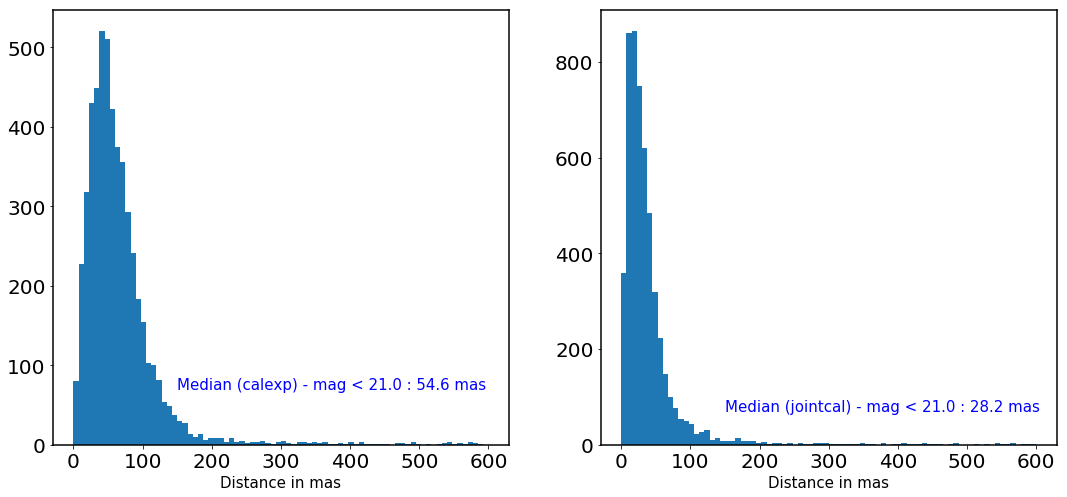

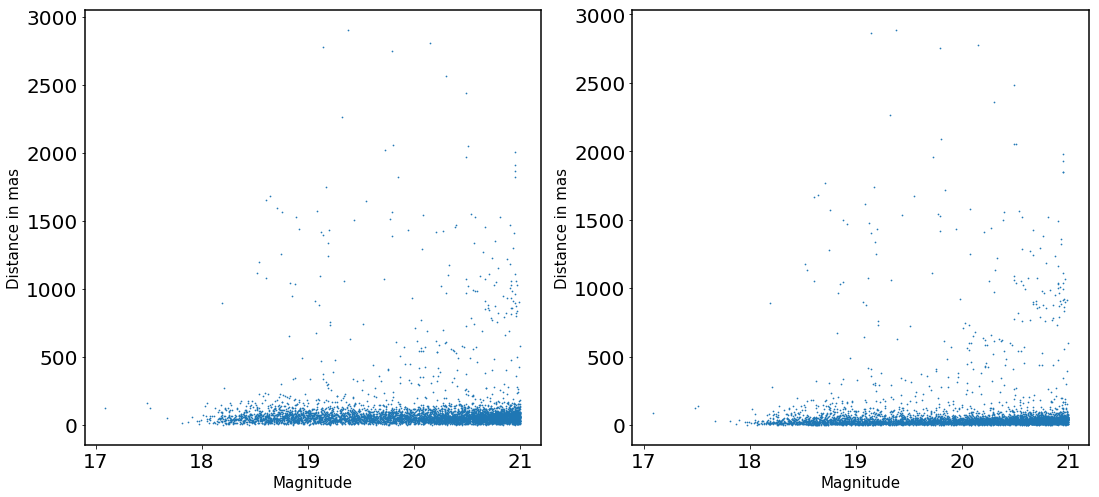

In [141]:
font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

magLim = 21.
f1 = T['mag'] < magLim
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(T['distOld'][f1], bins=80, range=[0., 600.])
ax1.hist(T['distNew'][f1], bins=80, range=[0., 600.])
ax0.tick_params(labelsize=20)
ax1.tick_params(labelsize=20)
ax0.set_xlabel('Distance in mas',fontsize=15)
ax1.set_xlabel('Distance in mas', fontsize=15)
ax0.text(150, 70, "Median (calexp) - mag < %0.1f : %0.1f mas"%(magLim, np.median(T['distOld'][f1])),
             fontsize=15, color='b')
ax1.text(150, 70, "Median (jointcal) - mag < %0.1f : %0.1f mas"%(magLim, np.median(T['distNew'][f1])),
             fontsize=15, color='b')

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.scatter(T['mag'][f1], T['distOld'][f1], s=0.5)
ax1.scatter(T['mag'][f1], T['distNew'][f1], s=0.5)
ax0.tick_params(labelsize=20)
ax1.tick_params(labelsize=20)
ax0.set_xlabel('Magnitude', fontsize=15)
ax1.set_xlabel('Magnitude', fontsize=15)
ax0.set_ylabel('Distance in mas', fontsize=15)
ax1.set_ylabel('Distance in mas', fontsize=15)

In [51]:
print src[100].getCoord()
print refCat[100].getCoord()

IcrsCoord(35.1468087, -5.1716459)
IcrsCoord(34.7045059, -4.7327262)


In [66]:
coordRef, coordVis, newWcs.pixelToSky(pixelsVis).toIcrs()

(IcrsCoord(35.12550652703722*afwGeom.degrees, -5.096041649089116*afwGeom.degrees),
 IcrsCoord(35.12548026943927*afwGeom.degrees, -5.09603146715465*afwGeom.degrees),
 IcrsCoord(35.12548184908841*afwGeom.degrees, -5.096029155751419*afwGeom.degrees))

12


(array([ 4.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.]),
 array([   9.32237911,   15.59904166,   21.87570422,   28.15236677,
          34.42902932,   40.70569187,   46.98235443,   53.25901698,
          59.53567953,   65.81234208,   72.08900464,   78.36566719,
          84.64232974,   90.91899229,   97.19565485,  103.4723174 ,
         109.74897995,  116.0256425 ,  122.30230505,  128.57896761,
         134.85563016,  141.13229271,  147.40895526,  153.68561782,
         159.96228037,  166.23894292,  172.51560547,  178.79226803,
         185.06893058,  191.34559313,  197.62225568,  203.89891824

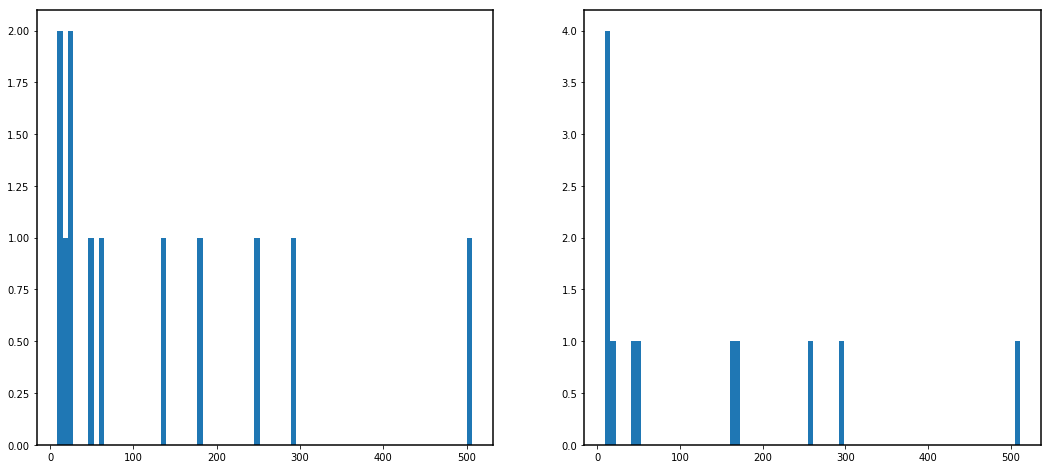

In [114]:
print(len(T['distOld']))
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(T['distOld'], bins=80)
ax1.hist(T['distNew'], bins=80)